In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [10]:
# Columns in the measurement table
inspector = inspect(engine)

measurement_info = inspector.get_columns('measurement')
print("measurement_info:")
for c in measurement_info:
    print(c['name'])

measurement_info:
id
station
date
prcp
tobs


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date_minus1year = (dt.datetime.strptime(recent_date[0],'%Y-%m-%d')-dt.timedelta(days=365)).strftime('%Y-%m-%d')
recent_date_minus1year

# Perform a query to retrieve the data and precipitation scores
measurement_table_col = (measurements.date, measurements.prcp)
measurement_data = session.query(*measurement_table_col).filter(measurements.date >= recent_date_minus1year).all()
measurement_data

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_data_df = pd.DataFrame(measurement_data, columns=["date", "precipitation"])
measurement_data_df.set_index("date", inplace=True)
measurement_data_df = measurement_data_df.sort_index()
measurement_data_df = measurement_data_df.dropna()
measurement_data_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


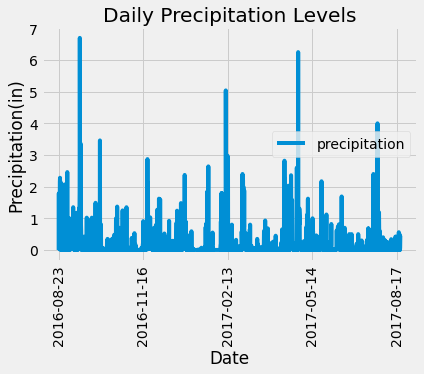

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = measurement_data_df.plot(rot=90);
ax.set_title("Daily Precipitation Levels");
ax.set_xlabel("Date");
ax.set_ylabel("Precipitation(in)");

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Columns in the station table
station_info = inspector.get_columns('station')
print("station_info:")
for c in station_info:
    print(c['name'])

station_info:
id
station
name
latitude
longitude
elevation


In [17]:
# Design a query to calculate the total number stations in the dataset
station_num = session.query(stations.id).count()
station_num

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(measurements.station, func.count(measurements.station)).group_by(measurements.station).\
                 order_by(func.count(measurements.station).desc()).all()
active_station
the_active_station = active_station[0][0]
print(the_active_station)

USC00519281


In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(*measurement_table_col).filter(measurements.station == the_active_station).all()
most_active
# most_active_df = pd.DataFrame(most_active, columns=("Station", "Precipitation"))
# min = most_active_df["Precipitation"].min()
# avg = most_active_df["Precipitation"].mean()
# max = most_active_df["Precipitation"].max()
# session.query(func.max(Table.column)) 
min = session.query(func.min(measurements.prcp)).all()
avg = session.query(func.avg(measurements.prcp)).all() 
max = session.query(func.max(measurements.prcp)).all() 
print(f"The 'MIN' is {min[0][0]}.")
print(f"The 'AVG' is {avg[0][0]}.")
print(f"The 'MAX' is {max[0][0]}.")

The 'MIN' is 0.0.
The 'AVG' is 0.16064353974479206.
The 'MAX' is 11.53.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff68744e400>]],
      dtype=object)

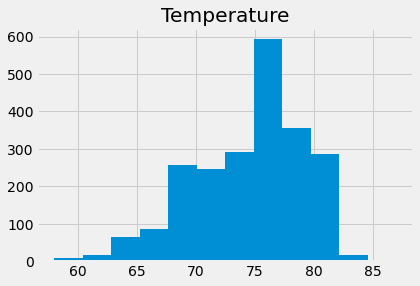

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
measurement_table_col2nd = (measurements.date, measurements.tobs)
most_active_12mo = session.query(*measurement_table_col2nd).filter(measurements.date >=recent_date_minus1year).all()
# Creating dataframe with datay from query
most_active_12mo_df = pd.DataFrame(most_active_12mo, columns=("Date", "Temperature"))
# Droping NA values
most_active_12mo_df = most_active_12mo_df.dropna()
# Setting index to 'Date' column
most_active_12mo_df.set_index("Date", inplace=True)
# Sorting the index so it's in order by date
most_active_12mo_df = most_active_12mo_df.sort_index()
# Plotting data to histogram
most_active_12mo_df.hist(bins=12)

# Close session

In [45]:
# Close Session
session.close()